In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client
from pint import UnitRegistry

import utils

units = UnitRegistry()
units.define('micromoles_per_kilogram = umol / kg') # used in WOA datasets

%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

cmocean       2.0
cftime        1.0.3.4
matplotlib    3.1.2
intake        0.5.3
ncar_jobqueue 2019.10.16.1
esmlab        2019.4.27.post55
intake_esm    2019.10.15.post40
xarray        0.14.0
cartopy       0.17.0
numpy         1.17.3
Mike Levy 2019-12-23 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper12
Git hash   : a95b42d188b011415c0cf6ae5301c7d6e286fa60


In [2]:
cluster = ncar_jobqueue.NCARCluster(project='P93300606')
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.218:36688 Dashboard: https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
cluster.scale(8)

In [4]:
def _read_var(dq, time_slice, variable):
    # Define datasets
    dataset = dq['ocn.historical.pop.h']

    keep_vars = ['REGION_MASK', 'z_t', 'dz', 'TAREA', 'TLONG', 'TLAT', 'time', 'time_bound', 'member_id', 'ctrl_member_id'] + [variable]
    dataset = dataset.drop([v for v in dataset.variables if v not in keep_vars]).sel(time=time_slice).mean(dim=['member_id', 'time']).compute()

    return(dataset)

In [5]:
def read_var_WOA(variable):
    woa_root=os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects',
                          'cesm2-marbl', 'woa2018-data', 'POP_gx1v7', 'annual')
    varmap = {'NO3' : 'n', 'PO4' : 'p', 'SiO3' : 'i'}
    filename=f'woa18_all_{varmap[variable]}00_gx1v7.nc'
    ds=xr.open_dataset(os.path.join(woa_root, filename), decode_times=False).isel(time=0)
    return(ds)

In [6]:
nutrients = ['NO3', 'PO4', 'SiO3']

In [7]:
%%time

catalog = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign-cesm2-cmip6-timeseries.json')

da_surf = dict()
ds = dict()
da_surf_obs = dict()
ds_obs = dict()

for variable in nutrients:
    # Read CESM and WOA data
    dq = catalog.search(experiment='historical', component='ocn', variable=variable).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
    ds[variable] = _read_var(dq, slice("1990-01-15", "2015-01-15"), variable) # 1990 - 2014, inclusive
    ds_obs[variable] = read_var_WOA(variable)

    da_tmp = ds[variable][variable]
    da_surf[variable] = (da_tmp.isel(z_t=0).data * units[ds[variable][variable].attrs['units']])
    da_tmp = ds_obs[variable][variable]
    da_surf_obs[variable]=da_tmp.isel(z_t=0).data * units[da_tmp.attrs['units']] * (1026*units['kg/m^3'])

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
CPU times: user 26.8 s, sys: 2.85 s, total: 29.6 s
Wall time: 6min 54s


In [8]:
%%time

da_zonal_mean = dict()
da_zonal_mean_obs = dict()
for var in nutrients:
    ds_tmp = utils.zonal_mean_via_fortran(ds[var], var, grid='gx1v7')
    da_zonal_mean[var] = ds_tmp[var]
    ds_tmp = utils.zonal_mean_via_fortran(ds_obs[var], var, grid='gx1v7')
    da_zonal_mean_obs[var] = ds_tmp[var]

za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
CPU times: user 364 ms, sys: 274 ms, total: 638 ms
Wall time: 2.53 s


In [9]:
def plot_surface_vals(variable, ds, da, obs):
    TLONG = ds[variable].TLONG
    TLAT = ds[variable].TLAT
    computed = da[variable]
    observed = obs[variable]   
    bias=computed-observed # convert to /vol rather than /mass

    # Determine contours
    min_lev = 0
    if variable == 'NO3':
        max_lev = 42
    if variable == 'PO4':
        max_lev = 3.2
    if variable == 'SiO3':
        max_lev = 180
    levels = MaxNLocator(nbins=15).tick_values(min_lev, max_lev)
    cmap = plt.get_cmap('rainbow')
    norm = BoundaryNorm(levels, ncolors=cmap.N)

    fig = plt.figure(figsize=(8, 14))
    ax = plt.subplot(3, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       computed.to('mmol/m^3').magnitude,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(),
                       norm=norm)

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'{variable} from POP run');
    cb.set_label('$\mathrm{mmol/m^3}$')

    ax = plt.subplot(3, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       observed.to('mmol/m^3').magnitude,
                       cmap=cmap,
                       transform=ccrs.PlateCarree(),
                       norm=norm)

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'{variable} from WOA');
    cb.set_label('$\mathrm{mmol/m^3}$')
    
    ax = plt.subplot(3, 1, 3, projection=ccrs.Robinson(central_longitude=305.0))

    pc = ax.pcolormesh(TLONG,
                       TLAT,
                       bias.to('mmol/m^3').magnitude,
                       cmap=plt.get_cmap('bwr'),
                       transform=ccrs.PlateCarree())

    # ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
    #                                                    edgecolor='face',
    #                                                    facecolor='lightgray'))
    ax.set_global() 
    ax.coastlines(linewidth=0.5)
    cb = plt.colorbar(pc, shrink=0.6)
    ax.set_title(f'Bias in {variable}');
    cb.set_label('$\mathrm{mmol/m^3}$')


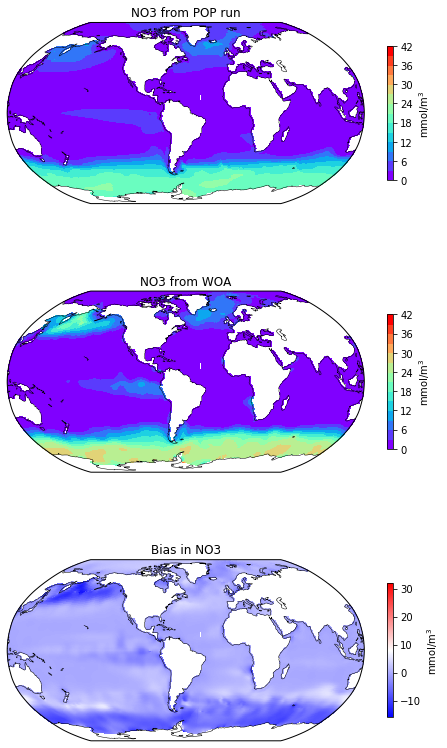

In [10]:
plot_surface_vals('NO3', ds, da_surf, da_surf_obs)

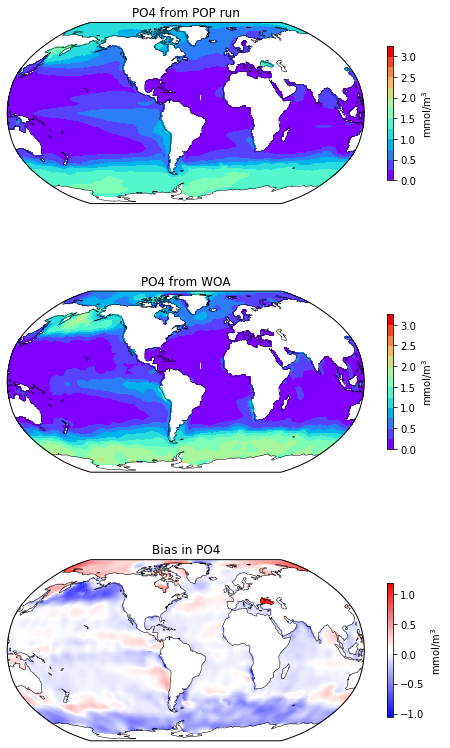

In [11]:
plot_surface_vals('PO4', ds, da_surf, da_surf_obs)

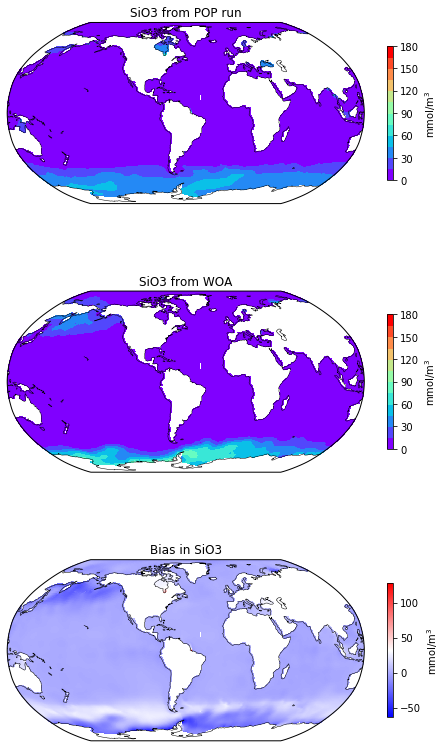

In [12]:
plot_surface_vals('SiO3', ds, da_surf, da_surf_obs)

## Compute global profile

Here we use `esmlab` to average over lat / lon, but leave depth

In [13]:
%%time

glb_avg = dict()
glb_avg_obs = dict()

for variable in nutrients:
    print(f'Computing weighted mean of {variable} for CESM output...')
    da_tmp = esmlab.weighted_mean(ds[variable][variable], weights=ds[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg[variable] = (da_tmp.data * units[ds[variable][variable].attrs['units']])

    print(f'Computing weighted mean of {variable} for WOA data...')
    da_tmp = esmlab.weighted_mean(ds_obs[variable][variable], weights=ds_obs[variable].TAREA, dim=['nlat', 'nlon']).compute()
    glb_avg_obs[variable] = ((da_tmp.data * units[ds_obs[variable][variable].attrs['units']]) * (1026*units['kg/m^3'])).to('mmol/m^3')


Computing weighted mean of NO3 for CESM output...
Computing weighted mean of NO3 for WOA data...
Computing weighted mean of PO4 for CESM output...
Computing weighted mean of PO4 for WOA data...
Computing weighted mean of SiO3 for CESM output...
Computing weighted mean of SiO3 for WOA data...
CPU times: user 532 ms, sys: 329 ms, total: 861 ms
Wall time: 964 ms


In [14]:
def plot_global_profile(variables, ds, da, obs):
    plt_cnt = len(variables)
    z = ds[variables[0]].z_t.data * units[ds[variables[0]]['z_t'].attrs['units']]

    fig = plt.figure(figsize=(4*plt_cnt, 4))
    for n, variable in enumerate(variables):
        computed = da[variable]
        observed = obs[variable]   

        ax = fig.add_subplot(1, plt_cnt, n+1)

        ax.plot(computed.magnitude, (z.to('m')).magnitude, 'b-', label='CESM2', linewidth=2)
        ax.plot(observed.magnitude, (z.to('m')).magnitude, 'r:', label='WOA2018', linewidth=2)

        ax.set_title(f'Global Profile of {variable}')
        ax.set(xlabel='concentration (mmol m$^{-3}$)')
        if n == 0:
            ax.set(ylabel='depth (m)')
        else:
            ax.set_yticklabels('')
        plt.gca().invert_yaxis()
        ax.legend()

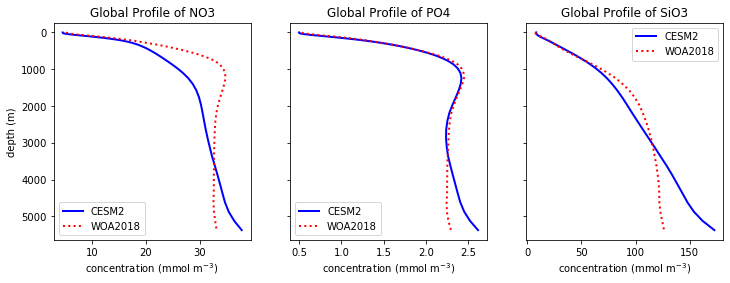

In [15]:
plot_global_profile(nutrients, ds, glb_avg, glb_avg_obs)

## Regional Plots

Regions based on code in POP repository:

```
$ cat input_templates/gx1v7_region_ids
   1  'Southern Ocean    '        0.0   0.0      0.0
   2  'Pacific Ocean     '        0.0   0.0      0.0
   3  'Indian Ocean      '        0.0   0.0      0.0
   4  'Persian Gulf      '       22.0  60.0      0.0
  -5  'Red Sea           '       14.0  47.0      3.0e15
   6  'Atlantic Ocean    '        0.0   0.0      0.0
   7  'Mediterranean Sea '       36.0 354.0      0.0
   8  'Labrador Sea      '        0.0   0.0      0.0
   9  'GIN Sea           '        0.0   0.0      0.0
  10  'Arctic Ocean      '        0.0   0.0      0.0
  11  'Hudson Bay        '       61.0 295.0      0.0
 -12  'Baltic Sea        '       56.0   8.0      3.0e15
 -13  'Black Sea         '       40.0  25.0      3.0e15
```

In [16]:
# In Keith's zon_avg tool, region is indexed by basin_id
# basin_id=0 => global
# basin_id = |region_id| => region (from table above)

regions = dict()
regions['Global'] = 0
regions['Southern Ocean'] = 1
regions['Pacific Ocean'] = 2
regions['Indian Ocean'] = 3
regions['Atlantic Ocean'] = 6

da_regional = dict()
da_regional_obs = dict()
for region in regions:
    da_regional[region] = dict()
    da_regional_obs[region] = dict()
    for variable in nutrients:
        # Note that we store a pint object to track units at this stage
        da_regional[region][variable] = da_zonal_mean[variable].isel(basins=regions[region]).data * units[da_zonal_mean[var].attrs['units']]
        da_regional_obs[region][variable] = da_zonal_mean_obs[variable].isel(basins=regions[region]).data * units[da_zonal_mean_obs[var].attrs['units']] * (1026*units['kg/m^3'])

In [17]:
def return_magnitude_in_units(pint_obj, units):
    return((pint_obj.to('mmol/m^3')).magnitude)

In [18]:
for var_tmp in nutrients:
    cesm = return_magnitude_in_units(da_regional['Global'][var_tmp], 'mmol/m^3')
    woa = return_magnitude_in_units(da_regional_obs['Global'][var_tmp], 'mmol/m^3')
    bias = cesm - woa
    print(f'{var_tmp}\n----')
    print(f'CESM range: {np.nanmin(cesm)}, {np.nanmax(cesm)}')
    print(f'WOA range: {np.nanmin(woa)}, {np.nanmax(woa)}')
    print(f'Bias max: {np.nanmax(np.abs(bias))}\n')

NO3
----
CESM range: 0.19594231247901917, 47.77882385253906
WOA range: 0.21855227649211884, 40.13529968261719
Bias max: 19.122671127319336

PO4
----
CESM range: 0.11029202491044998, 3.4720852375030518
WOA range: 0.10823500156402588, 3.0283310413360596
Bias max: 0.8206684589385986

SiO3
----
CESM range: 1.992660403251648, 265.53570556640625
WOA range: 1.7357105016708374, 223.22459411621094
Bias max: 79.23678588867188



In [19]:
lat = da_zonal_mean[nutrients[0]].lat_t.data
z = da_zonal_mean[nutrients[0]].z_t.data

def plot_zonal_averages_by_region(variables, region, da, obs, lat=lat, z=z):

    if type(variables) != list:
        variables = [variables]

    # For now use levels defined in Kristen's notebook
    levels = dict()
    levels['NO3'] = np.arange(0, 48, 4) # 0, 4, 8, ..., 40, 44
    levels['PO4'] = np.arange(0, 4.4, 0.4) # 0, 0.4, 0.8, ..., 3.6, 4.0
    levels['SiO3'] = np.concatenate((np.arange(0, 100, 10), np.arange(100, 300, 20))) # 0, 10, ... 90, 100, 120, 140, ..., 260, 280

    bias_levels = dict()
    bias_levels['NO3'] = np.arange(-18, 20, 3) # -18, -15, ..., 15, 18
    bias_levels['PO4'] = np.arange(-0.9, 1, 0.1) # -0.9, -0.8, ..., 0.8, 0.9
    bias_levels['SiO3'] = np.arange(-80, 85, 5) # -80, -75, -70, ..., 75, 80

    fig = plt.figure(figsize=(8*len(variables),12))
    plt.suptitle(f'Zonal Means ({region})', fontsize=14)

    # TOP: CESM

    for n, variable in enumerate(variables):
        cesm_out = return_magnitude_in_units(da[region][variable], 'mmol/m^3')
        woa_vals = return_magnitude_in_units(obs[region][variable], 'mmol/m^3')
        bias = cesm_out - woa_vals

        ax = fig.add_subplot(3, len(variables), n + 1)
        ax.set_title(f' {variable}\nCESM2')
        pc=ax.contourf(lat, z, cesm_out, levels=levels[variable], cmap='rainbow', extend='both')
        pc2 = ax.contour(lat, z, cesm_out, levels[variable], colors='k')
        ax.clabel(pc2, colors = 'k', fmt = '%2.1f', fontsize=10)
        if n==0:
            ax.set(ylabel='depth (m)')
        else:
            ax.set(ylabel='', yticklabels='')
        ax.set(xlabel='', xticklabels='')
        ax.invert_yaxis()

        #MIDDLE: WOA

        ax = fig.add_subplot(3, len(variables), (n + 1) + len(variables))
        ax.set_title(f'WOA')
        pc=ax.contourf(lat, z, woa_vals, levels=levels[variable], cmap='rainbow', extend='both')
        pc2 = ax.contour(lat, z, woa_vals, levels[variable], colors='k')
        ax.clabel(pc2, colors = 'k', fmt = '%2.1f', fontsize=10)
        if n==0:
            ax.set(ylabel='depth (m)')
        else:
            ax.set(ylabel='', yticklabels='')
        ax.set(xlabel='', xticklabels='')
        ax.invert_yaxis()

        #BOTTOM: Bias

        ax = fig.add_subplot(3, len(variables), (n + 1) + 2*len(variables))
        ax.set_title(f'CESM2 - WOA')
        pc=ax.contourf(lat, z, bias, levels=bias_levels[variable], cmap='bwr', extend='both')
        pc2 = ax.contour(lat, z, bias, bias_levels[variable], colors='k')
        ax.clabel(pc2, colors = 'k', fmt = '%2.1f', fontsize=10)
        if n==0:
            ax.set(ylabel='depth (m)')
        else:
            ax.set(ylabel='', yticklabels='')
        ax.set(xlabel='Latitude')
        ax.invert_yaxis()


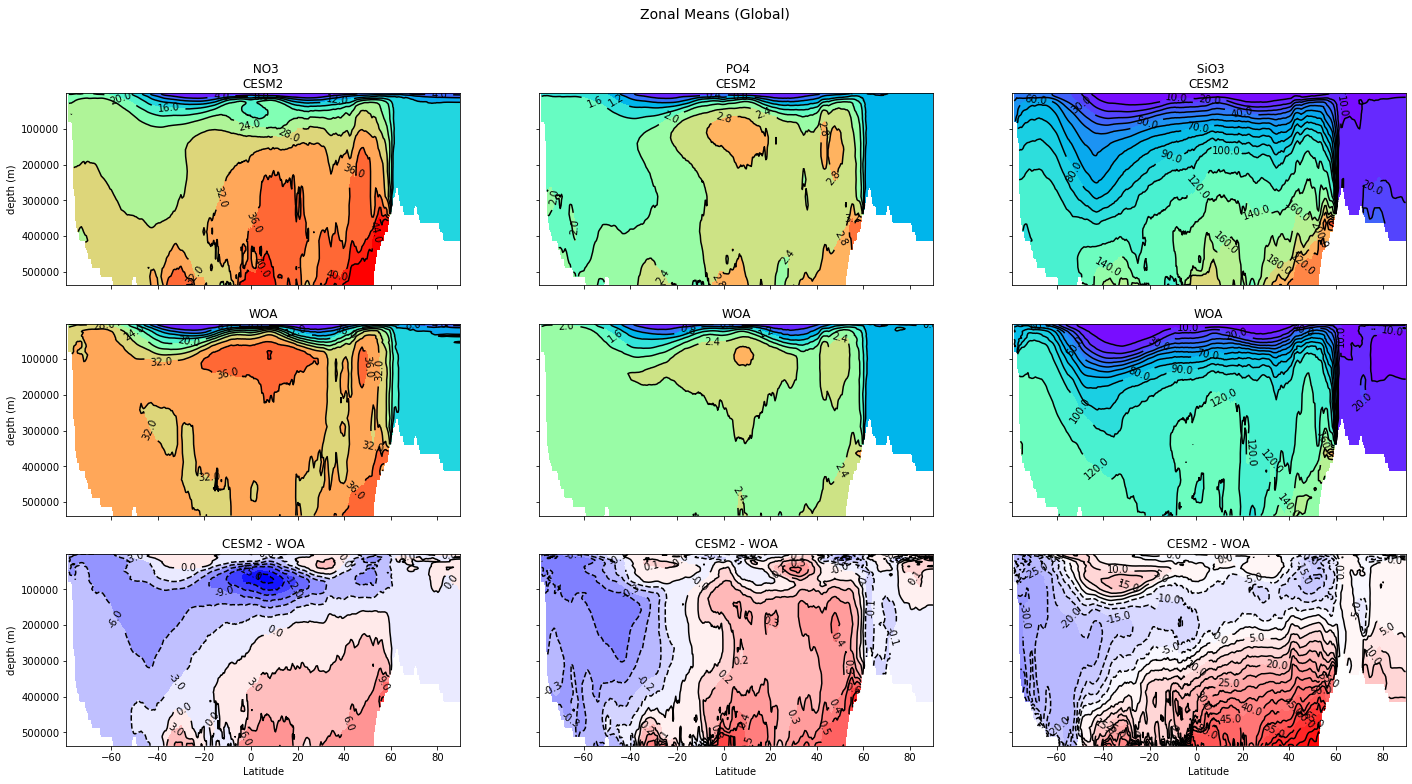

In [20]:
plot_zonal_averages_by_region(nutrients, 'Global', da_regional, da_regional_obs)

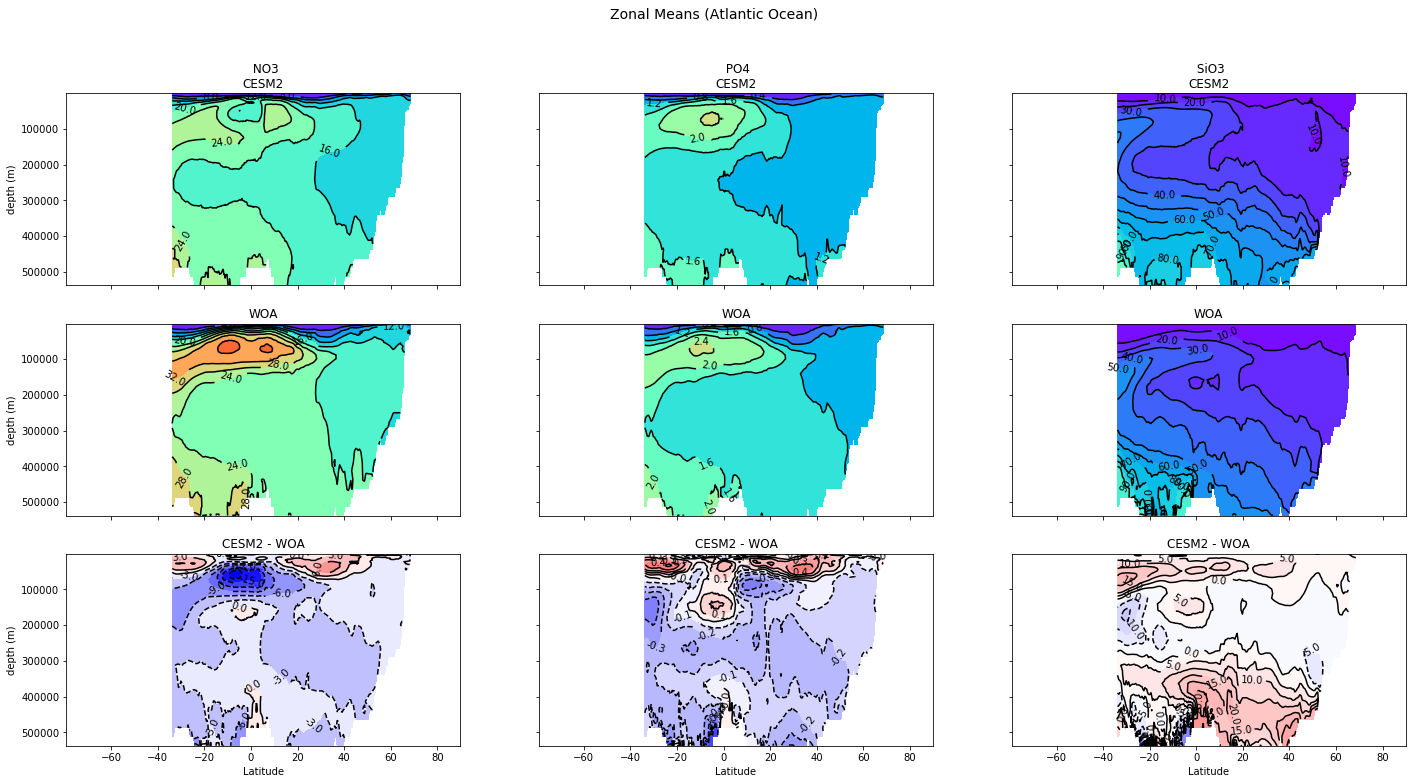

In [21]:
plot_zonal_averages_by_region(nutrients, 'Atlantic Ocean', da_regional, da_regional_obs)

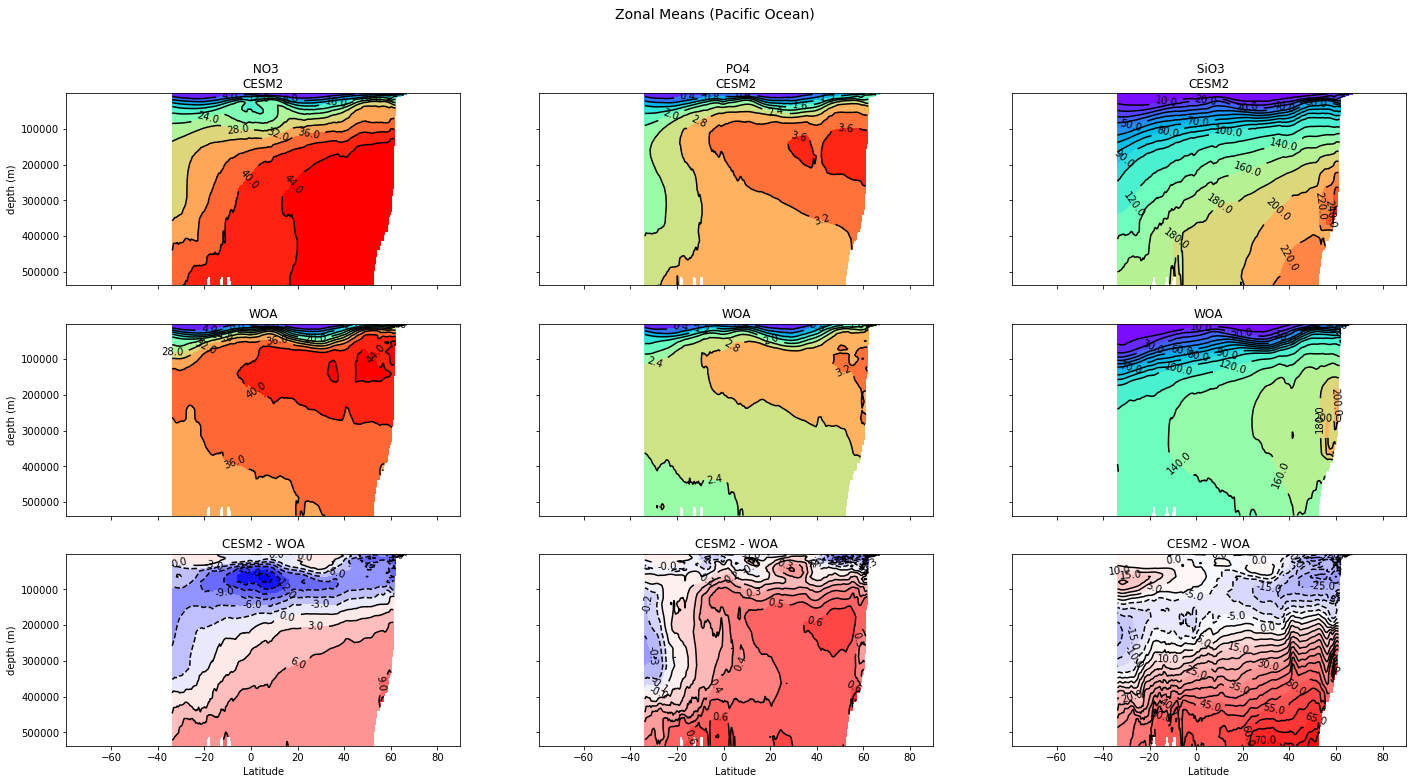

In [22]:
plot_zonal_averages_by_region(nutrients, 'Pacific Ocean', da_regional, da_regional_obs)

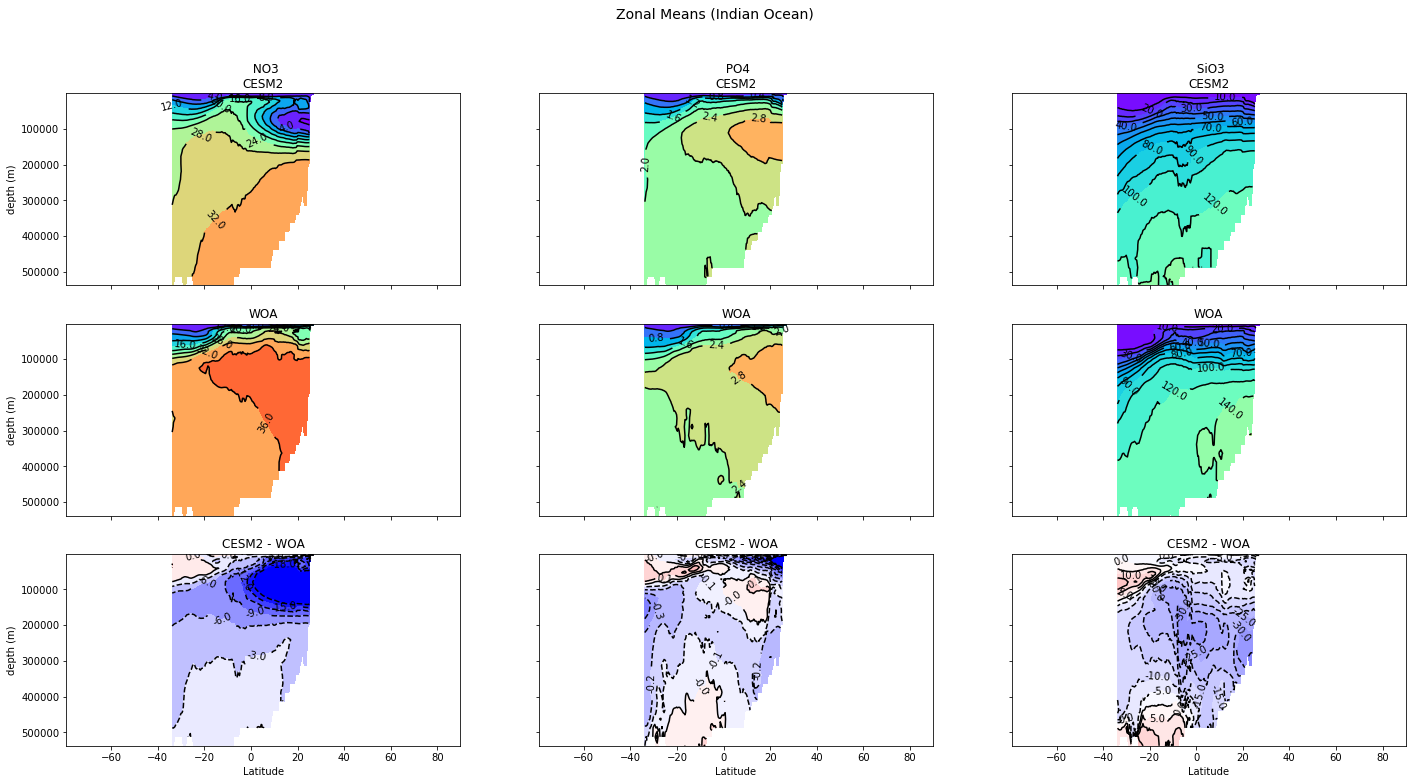

In [23]:
plot_zonal_averages_by_region(nutrients, 'Indian Ocean', da_regional, da_regional_obs)

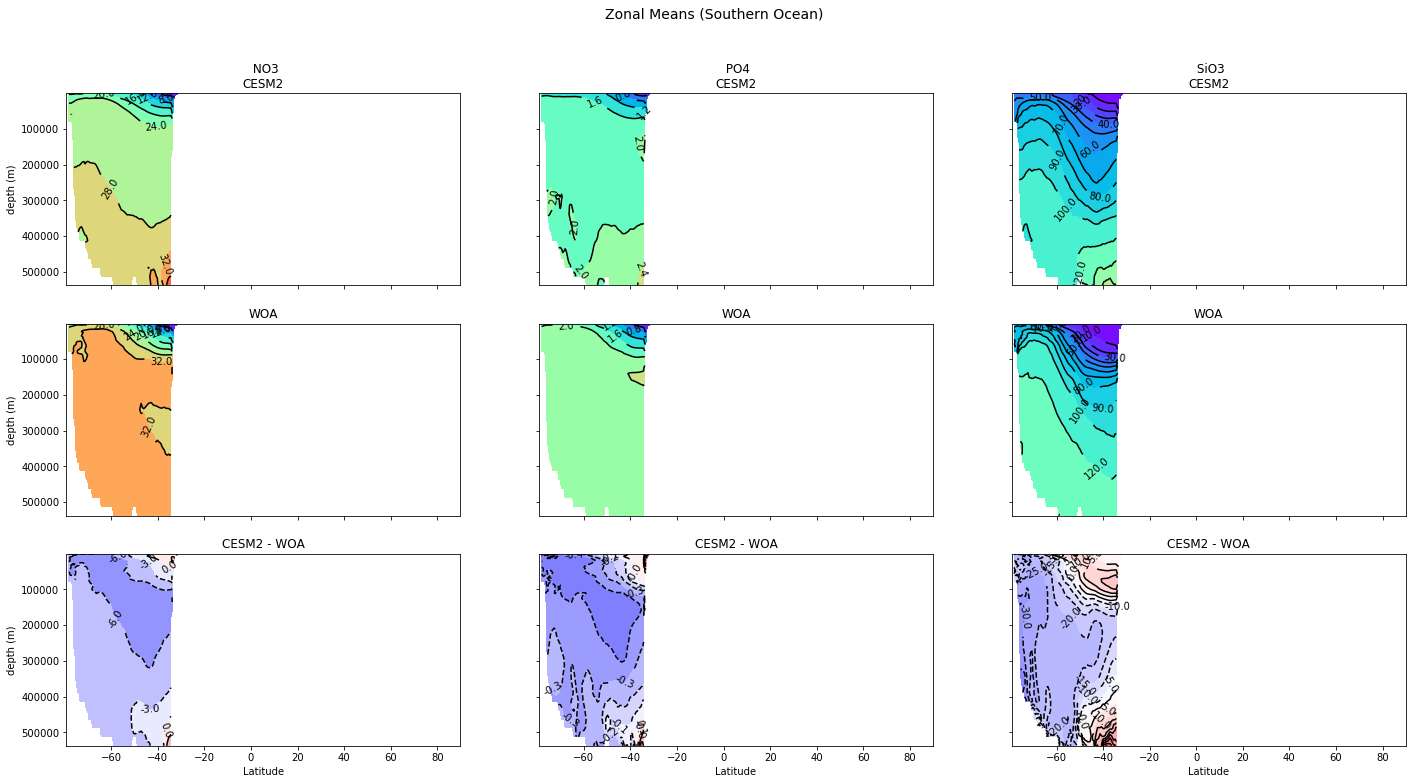

In [24]:
plot_zonal_averages_by_region(nutrients, 'Southern Ocean', da_regional, da_regional_obs)